# Make my own TfidVectoriser

The notebook consists of 3 sections. I create from scratch, something akin to the `TfidfVectorizer` in `sklearn` and explore concepts related to document search and query- how we can use euclidean and cosine distances between documents to identify documents that are most similar to each other.

The sections are:


   1) Visualise 2D heatmap of pairwise distances between all documents

   2) Challenge to get the euclidean distance between the "query document"  ("People who see ghosts") to be closer to the "target document" ("We have collected a report...") than any other document in the corpus. Report a ratio of next_closest/target, which should be > 1.
   
   3)  Additional experiments - are the euclidean distance and cosine distance are proportional? (preserve the relative distance between all the documents)



# Define corpus

In [599]:
docs = ['People who see ghosts',

        '"I dont believe people who see ghosts", said Mannie, before spitting into the wind and riding his bike down the street at top speed. He then went home and ate peanut-butter and jelly sandwiches all day. Mannie really liked peanut-butter and jelly sandwiches. He ate them so much that his poor mother had to purchase a new jar of peanut butter every afternoon.',

        'People see incredible things. One time I saw some people talking about things they were seeing, and those people were so much fun. They saw clouds and they saw airplanes. They saw dirt and they saw worms. Can you believe the amount of seeing done by these people? People are the best.',

        'This is an article about a circus. A Circus is where people go to see other people who perform great things. Circuses also have elephants and tigers, which generally get a big woop from the crowd.',

        'Lots of people have come down with Coronavirus. You can see the latest numbers and follow our updates on the pandemic below. Please, stay safe.',

        'Goats are lovely creatures. Many people love goats. People who love goats love seeing them play in the fields.',

        'We have collected a report of people in our community seeing ghosts. Each resident was asked "how many ghosts have you seen?", "describe the last ghost you saw", and "tell us about your mother." Afterwards, we compared the ghost reports between the different individuals, and assessed whether or not they were actually seeing these apparitions.']



# Import packages

In [600]:
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
not_alphanumeric_or_space = re.compile('[^(\w|\s|\d)]')

import nltk
from nltk.corpus import stopwords
set(stopwords.words('english'))
stop_words = stopwords.words('english')

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cosine as cos_dist

# Define functions

In [601]:
def preprocess(doc, stop_words): 
''' Remove alphanumeric characters, decapitalise, lemmatise and remove stop words'''
        doc = doc.replace('-', ' ')
        doc = re.sub(not_alphanumeric_or_space, '', doc).lower() 
        words = [stemmer.stem(word) for word in doc.split() if word not in stop_words]
        return(' '.join(words).lower())


def word_count(doc):
''' Create dictionary which counts unique words within a document'''
    word_dict = {}
    for word in doc.split():
        try: word_dict[str(word)] +=1
        except: word_dict[str(word)] = 1 # Exception will occur in cases where word is not yet in dictionary
    return(word_dict)


def all_docs(all_docs, stop_words):  
''' Loop over all documents; preprocess each document and perform word count on each doc
# Return list of word dictionaries (one per document)'''
    doc_list = [preprocess(doc, stop_words) for doc in all_docs]             
    dictionary_list = [word_count(doc) for doc in doc_list]                  
    return(dictionary_list)


def mergeDict(dict1, dict2): 
''' Merge 2 dictionaries'''
    dict3 = {}   
    for key, value in dict1.items():       
        if key in dict1 and key in dict2:
            dict3[key] = value + dict2[key]
        else: dict3[key] = value    
    for key, value in dict2.items():
        if key not in dict3:
            dict3[key] = value           
    return(dict3)


def consolidate_dics(list_of_dics, threshold = 1):
''' Merge a list of dictionaries, keeping only key/value pairs that occur over a threshold number of times'''
    super_dic = list_of_dics[0]
    for dic in range(1, len(list_of_dics)):
        super_dic = mergeDict(super_dic, list_of_dics[dic])    
    super_dic = {k: v for k, v in super_dic.items() if v > threshold}            

    return(super_dic)


def inverse_doc_freq(term, docs):
''' Calculate inverse document frequency'''
    df = sum([1 for doc in docs if term in doc])
    idf = np.log((len(docs)) / (df+1))
    return [0 if idf < 0 else idf] # As we have a small number of docs, it can happen that a term occurs in every  
                                   # doc- hence log(D/df+1) becomes negative. To negate this effect, we zero -ve vals


def create_idf_list(super_dic):
'''Create list of all idfs'''
    idf_list = []
    for key, value in super_dic.items():    
        idf_list.append(inverse_doc_freq(key, docs))
    return(idf_list)


def make_vectors(dictionary_list, super_dic):
'''Create numpy array of idf values for every docment  
    ...For only those words which appear in the super dictionary'''
    vector_list = []
    for dic in dictionary_list:
        dic_vector = []
        for key, value in super_dic.items():
            try: dic_vector.append(dic[key])
            except: dic_vector.append(0)
        dic_vector = np.add(dic_vector ,len(dic_vector) * [0.0000001])
        vector_list.append(dic_vector)
    return(vector_list)


def cos_dist(A, B):
'''Cosine distance as defined on wiki https://en.wikipedia.org/wiki/Cosine_similarity'''
    nom = np.sum(A*B)
    denom = np.linalg.norm(A) * np.linalg.norm(B)
    return(nom/denom)


def eucl_dist(A, B):
'''Euclidean distance as defined on wiki https://en.wikipedia.org/wiki/Euclidean_distance'''
    return((np.sum((A-B)**2))**0.5)


def pairwise_distance(X):
    N = X.shape[0]
    dists = np.zeros((N, N))
    for i, a in enumerate(X):
        for j, b in enumerate(X):
            dists[i, j] = np.linalg.norm(a - b)

    return dists

def get_score(vecs):
    dists = pairwise_distance(vecs)
    mxidx = np.argmin(dists[0][1:-1]) + 1
    next_best = np.linalg.norm(vecs[mxidx] - vecs[0]) 
    target = np.linalg.norm(vecs[-1] - vecs[0])
    score = next_best / target
    print('SCORE: ', score)

# Run code

In [5]:
# Preprocessing
tf_list = all_docs(docs, stop_words)

# Create super dictionary of all words in corpus (not stop words etc) over given frequency
super_dic = consolidate_dics(tf_list, threshold= 2)

# Create TF and IDF matrices
idf_list = create_idf_list(super_dic)
tf_matrix = make_vectors(tf_list, super_dic)
idf_matrix = [i * np.transpose(idf_list) for i in tf_matrix]

# Here we normalise the rows of the matrix so that the L2 norm is 1
norm_idf_matrix = [i/(eucl_dist(i, [0] * len(i))) for i in idf_matrix]
norm_idf_matrix = np.array(pd.DataFrame(np.concatenate(norm_idf_matrix)).fillna(0))

# Calculate document distances which are the basis for search comparisons
l2_norm = [round(np.linalg.norm(i),2) for i in norm_idf_matrix]
e_dists = [[eucl_dist(i ,j) for i in norm_idf_matrix] for j in norm_idf_matrix]
c_dists = [[cos_dist(i, j) for i in norm_idf_matrix] for j in norm_idf_matrix]

# Results

## 1) Visualise the pairwise distances between all the documents

In [613]:
pwise_dists = round(pd.DataFrame(pairwise_distance(norm_idf_matrix)),2)

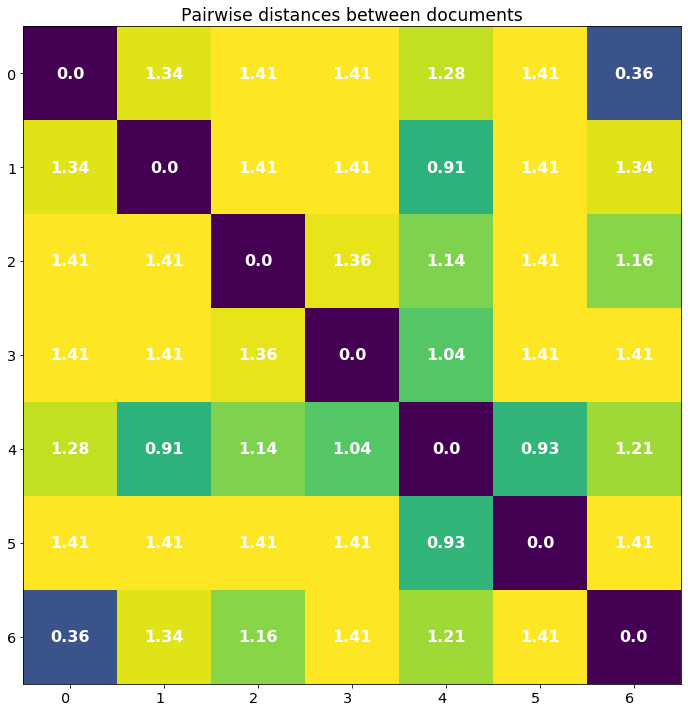

In [609]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(pwise_dists)

plt.setp(ax.get_xticklabels(),  ha="right", rotation_mode="anchor", size = 'x-large')
plt.setp(ax.get_yticklabels(),  ha="right", rotation_mode="anchor", size = 'x-large')

for i in range(pwise_dists.shape[0]):
    for j in range(pwise_dists.shape[1]):
        text = ax.text(j, i, pwise_dists.iloc[i, j],
                       ha="center", va="center", color="w", fontsize = 16, fontweight = 'bold')

ax.set_title("Pairwise distances between documents", size = 'xx-large')
fig.tight_layout()

plt.show()

## Comments

- Diagonal values are 0 (makes sense as documents have zero distance to themselves)
- Document 4 is most similar to all other documents because it contains 0 words in the super dictionary- so it has similarities with all other documents, which all have zero values for some (often several words)
- Documents 1 and 0 are more similar because they both contain the word 'ghost' which has a high IDF score, documents 2 and 1 are more similar because they both contain the words 'people,' 'see,' and zeros for the other words in the super dictionary.
- Document 6 is most similar to our search term

## 2) Get the euclidean distance between the "query document"  to be closer to the "target document"

In [570]:
get_score(norm_idf_matrix)

SCORE:  3.5570604056289983


### Comments
- In order to optimise our search for our specific search term, I have created vectors based on only a small amount of words in each document(non stop-words, words that occur > threshold number in all documents) and then weighted these according to their idf_matrix. This works well for this query, but you can see that it would be difficult to differentiate between other documents in the matrix. It might require further tuning for more general search terms!

In [630]:
super_dic

{'peopl': 13,
 'see': 10,
 'ghost': 6,
 'peanut': 3,
 'butter': 3,
 'thing': 3,
 'saw': 6,
 'circus': 3,
 'goat': 3,
 'love': 4}

## 3) Show that the euclidean distance and cosine distance are proportional 

In [569]:
pd.DataFrame(pairwise_distance(norm_idf_matrix))

,0,1,2,3,4,5,6
0,0.000000,1.338125,1.414213,1.414213,1.280115,1.414213,0.359880
1,1.338125,0.000000,1.414214,1.414214,0.908081,1.414214,1.343183
2,1.414213,1.414214,0.000000,1.355227,1.135306,1.414214,1.158718
3,1.414213,1.414214,1.355227,0.000000,1.044353,1.414214,1.414214
4,1.280115,0.908081,1.135306,1.044353,0.000000,0.931478,1.211791
5,1.414213,1.414214,1.414214,1.414214,0.931478,0.000000,1.414214
6,0.359880,1.343183,1.158718,1.414214,1.211791,1.414214,0.000000


In [2]:
# Show that the normalised IDF matrix is normalised! i.e.  each row has an l2 norm of 1.
# This is essential otherwise we wont see that the euclidean distance and cosine distance are proportional
l2_norm

In [660]:
# The Euclidean distances are correctly calculated (see 2 methods produce same results)

round(pd.DataFrame(e_dists),5)

,0,1,2,3,4,5,6
0,0.00000,1.33812,1.41421,1.41421,1.28012,1.41421,0.35988
1,1.33812,0.00000,1.41421,1.41421,0.90808,1.41421,1.34318
2,1.41421,1.41421,0.00000,1.35523,1.13531,1.41421,1.15872
3,1.41421,1.41421,1.35523,0.00000,1.04435,1.41421,1.41421
4,1.28012,0.90808,1.13531,1.04435,0.00000,0.93148,1.21179
5,1.41421,1.41421,1.41421,1.41421,0.93148,0.00000,1.41421
6,0.35988,1.34318,1.15872,1.41421,1.21179,1.41421,0.00000


In [661]:
e_dists_2 = [[ np.linalg.norm(i-j) for i in norm_idf_matrix] for j in norm_idf_matrix]

round(pd.DataFrame(e_dists_2),5)

,0,1,2,3,4,5,6
0,0.00000,1.33812,1.41421,1.41421,1.28012,1.41421,0.35988
1,1.33812,0.00000,1.41421,1.41421,0.90808,1.41421,1.34318
2,1.41421,1.41421,0.00000,1.35523,1.13531,1.41421,1.15872
3,1.41421,1.41421,1.35523,0.00000,1.04435,1.41421,1.41421
4,1.28012,0.90808,1.13531,1.04435,0.00000,0.93148,1.21179
5,1.41421,1.41421,1.41421,1.41421,0.93148,0.00000,1.41421
6,0.35988,1.34318,1.15872,1.41421,1.21179,1.41421,0.00000


In [662]:
# The cosine distances are correctly calculated (see 2 different methods below)

round(pd.DataFrame(c_dists),5)

,0,1,2,3,4,5,6
0,0.00000,0.89529,1.00000,1.00000,0.81935,1.00000,0.06476
1,0.89529,0.00000,1.00000,1.00000,0.41231,1.00000,0.90207
2,1.00000,1.00000,0.00000,0.91832,0.64446,1.00000,0.67131
3,1.00000,1.00000,0.91832,0.00000,0.54534,1.00000,1.00000
4,0.81935,0.41231,0.64446,0.54534,0.00000,0.43383,0.73422
5,1.00000,1.00000,1.00000,1.00000,0.43383,0.00000,1.00000
6,0.06476,0.90207,0.67131,1.00000,0.73422,1.00000,0.00000


In [663]:
c_dists_2 = [[cos_dist(i, j) for i in norm_idf_matrix] for j in norm_idf_matrix]
pd.DataFrame(c_dists_2)

,0,1,2,3,4,5,6
0,0.000000,0.895289,1.000000,1.000000,0.819347,1.000000,0.064757
1,0.895289,0.000000,1.000000,1.000000,0.412305,1.000000,0.902070
2,1.000000,1.000000,0.000000,0.918321,0.644460,1.000000,0.671314
3,1.000000,1.000000,0.918321,0.000000,0.545336,1.000000,1.000000
4,0.819347,0.412305,0.644460,0.545336,0.000000,0.433826,0.734218
5,1.000000,1.000000,1.000000,1.000000,0.433826,0.000000,1.000000
6,0.064757,0.902070,0.671314,1.000000,0.734218,1.000000,0.000000


In [665]:
# But the distances dont seem to be proportional!
round(pd.DataFrame(e_dists)/pd.DataFrame(c_dists_2), 2)

,0,1,2,3,4,5,6
0,NaN,1.49,1.41,1.41,1.56,1.41,5.56
1,1.49,NaN,1.41,1.41,2.20,1.41,1.49
2,1.41,1.41,NaN,1.48,1.76,1.41,1.73
3,1.41,1.41,1.48,NaN,1.92,1.41,1.41
4,1.56,2.20,1.76,1.92,NaN,2.15,1.65
5,1.41,1.41,1.41,1.41,2.15,NaN,1.41
6,5.56,1.49,1.73,1.41,1.65,1.41,NaN
